In [1]:
import torch
from fuxi import *

data_dir = 'data'
model_dir = '/cache' # change to your model dir

device = 'cuda' # FuXi can run on cpu with float32
dtype = torch.float16 
# FuXi's default format is bfloat16. Although other formats may still function, their accuracy has not been tested.

# fuxi hyper parameters
in_chans = 75
in_frames = 2
out_frames = 1
out_chans = 70
embed_dim = 1536
num_heads = 24
depths = [12, 12, 12, 12]
image_size = (720, 1440)
patch_size = 4
down_times = 1
window_size = 9

freq = 6 # 6 hour interval 
step_range = [20, 20, 20] # each decoder run for 20 steps (5 day)
num_steps = sum(step_range) # 60 steps for 15 day


decoder = UTransformer(
    in_chans=in_chans,
    out_chans=out_chans,
    in_frames=in_frames,
    image_size=image_size,
    window_size=window_size,
    patch_size=patch_size,
    down_times=down_times,
    embed_dim=embed_dim,
    num_heads=num_heads,
    depths=depths,
)


# define fuxi model
model = FuXi(
    in_frames=in_frames,
    out_frames=out_frames,
    step_range=step_range,
    decoder=[decoder, decoder, decoder],
    device=device,
    dtype=dtype,
).to(dtype=dtype, device=device).eval()

In [2]:
# load weight and buffer 
model.load(model_dir, fmt='st') # in safetensor format

load from /cache/fuxi_short.st ...
load from /cache/fuxi_medium.st ...
load from /cache/fuxi_long.st ...
load from /cache/buffer.st ...


In [4]:
import os
import numpy as np
import xarray as xr
import pandas as pd

data = xr.open_dataarray(os.path.join(data_dir, "input.nc"))

init_time = pd.to_datetime(data.time.values[-1])
print(f"init_time: {init_time}")

# precompute time encoding
tembs = time_encoding(init_time, num_steps=num_steps, freq=freq)
tembs = tembs.to(device)
input = torch.from_numpy(data.values).to(device)

print(f'input: {input.shape}, {input.min():.2f} ~ {input.max():.2f}')
print(f'tembs: {tembs.shape}, {tembs.min():.2f} ~ {tembs.max():.2f}')

init_time: 2018-01-01 12:00:00
input: torch.Size([2, 70, 720, 1440]), -4189.11 ~ 203672.08
tembs: torch.Size([60, 1, 12]), 0.00 ~ 1.00


In [5]:
# run inference
output = model([input, tembs]).cpu().numpy()
print(f'output: {output.shape}, {output.min():.2f} ~ {output.max():.2f}')

stage: 0, step: 01
stage: 0, step: 02
stage: 0, step: 03
stage: 0, step: 04
stage: 0, step: 05
stage: 0, step: 06
stage: 0, step: 07
stage: 0, step: 08
stage: 0, step: 09
stage: 0, step: 10
stage: 0, step: 11
stage: 0, step: 12
stage: 0, step: 13
stage: 0, step: 14
stage: 0, step: 15
stage: 0, step: 16
stage: 0, step: 17
stage: 0, step: 18
stage: 0, step: 19
stage: 0, step: 20
stage: 1, step: 21
stage: 1, step: 22
stage: 1, step: 23
stage: 1, step: 24
stage: 1, step: 25
stage: 1, step: 26
stage: 1, step: 27
stage: 1, step: 28
stage: 1, step: 29
stage: 1, step: 30
stage: 1, step: 31
stage: 1, step: 32
stage: 1, step: 33
stage: 1, step: 34
stage: 1, step: 35
stage: 1, step: 36
stage: 1, step: 37
stage: 1, step: 38
stage: 1, step: 39
stage: 1, step: 40
stage: 2, step: 41
stage: 2, step: 42
stage: 2, step: 43
stage: 2, step: 44
stage: 2, step: 45
stage: 2, step: 46
stage: 2, step: 47
stage: 2, step: 48
stage: 2, step: 49
stage: 2, step: 50
stage: 2, step: 51
stage: 2, step: 52
stage: 2, st

In [7]:
# save output 
output = xr.DataArray(
    output,
    dims=['time', 'lead_time', 'channel', 'lat', 'lon'],
    coords=dict(
        time=[init_time],
        lead_time=(1 + np.arange(num_steps)) * freq,
        channel=data.channel,
        lat=data.lat,
        lon=data.lon,
    )
)

save_name = os.path.join(data_dir, "output.nc")
output.to_netcdf(save_name)

vi: 226.36 ~ 312.90
vo: 225.89 ~ 311.47


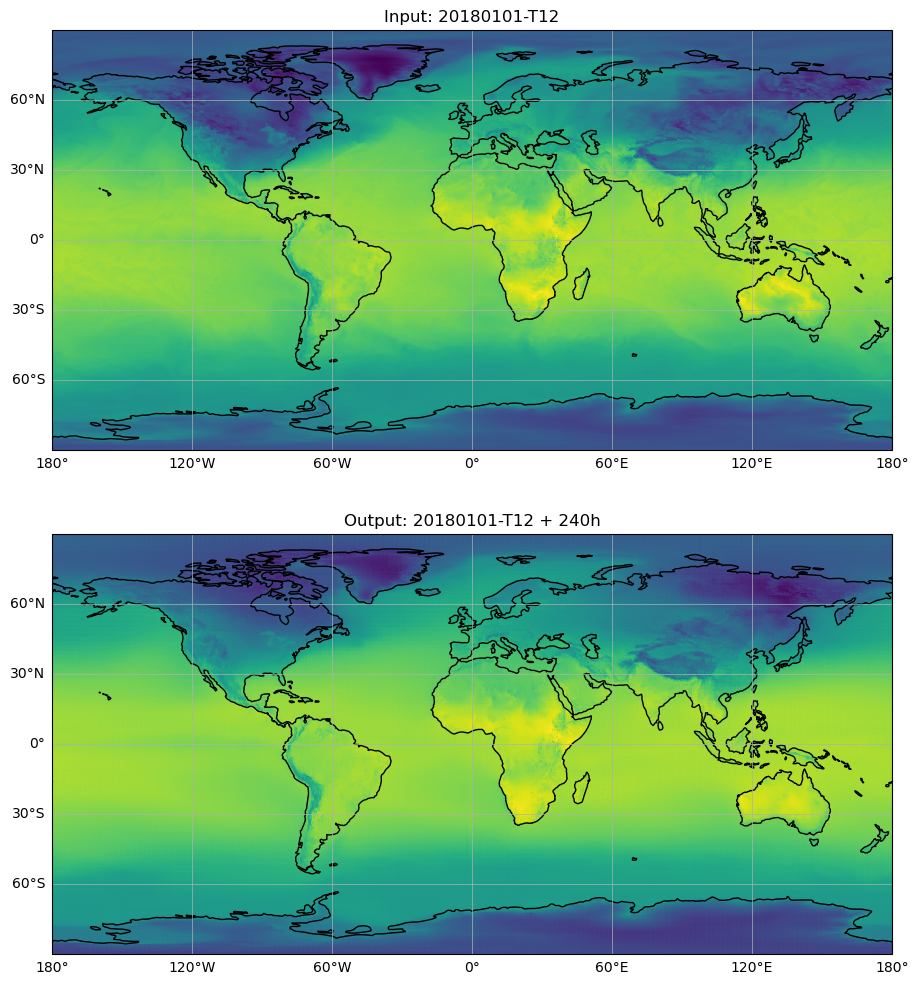

In [8]:
import matplotlib.pyplot as plt 
import cartopy.crs as ccrs


def plot(ds, ax, title):

    ds.plot(
        ax=ax, 
        x='lon', 
        y='lat', 
        transform=ccrs.PlateCarree(),  
        add_colorbar=False
    )
    ax.set_title(title)
    ax.coastlines()
    gl = ax.gridlines(draw_labels=True, linewidth=0.5)
    gl.top_labels = False
    gl.right_labels = False    


name = 't2m'
lead_time = 240
init_time = '20180101-T12'
fcst_time = pd.to_datetime(init_time) + pd.Timedelta(hours=lead_time)

output = xr.open_dataarray(os.path.join(data_dir, 'output.nc'))

vi = data.sel(time=init_time, channel=name)
vo = output.sel(time=init_time, lead_time=lead_time, channel=name)

print(f'vi: {vi.min().values:.2f} ~ {vi.max().values:.2f}')
print(f"vo: {vo.min().values:.2f} ~ {vo.max().values:.2f}")

fig, ax = plt.subplots(2, 1, figsize=(12, 12), subplot_kw={"projection": ccrs.PlateCarree()})
plot(vi, ax[0], title=f'Input: {init_time}')
plot(vo, ax[1], title=f'Output: {init_time} + {lead_time:03d}h')